## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

## The Arcface loss class

In [ ]:
!pip install tensorflow==2.4.0

In [1]:

from tensorflow import keras 

from keras import regularizers



# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow

from keras import backend as K
from keras.layers import Layer
from keras.metrics import categorical_accuracy

import tensorflow as tf
import math as m


class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



### Alternative implementation of arcface

In [ ]:
from keras import backend as K
from keras.layers import Layer
from keras import regularizers

import tensorflow as tf


class ArcFace(Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)


#### Importing the necessary packages

In [2]:
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import load_model

In [3]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Training/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Apass count:  31
Name:  Becky count:  39
Name:  Canary count:  39
Name:  Cindy count:  52
Name:  Gamzi count:  30
Name:  Kabuura count:  23
Name:  Katatumba count:  62
Name:  KenMugabi count:  59
Name:  Lucky count:  57
Name:  Nabata count:  48
Name:  Raymond count:  21
Name:  Renal count:  26
Name:  Ruth count:  20
Name:  Samson count:  68
Name:  Vanny count:  38


In [4]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Validation/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Apass count:  9
Name:  Becky count:  10
Name:  Canary count:  17
Name:  Cindy count:  17
Name:  Gamzi count:  9
Name:  Kabuura count:  8
Name:  Katatumba count:  20
Name:  KenMugabi count:  14
Name:  Lucky count:  16
Name:  Nabata count:  22
Name:  Raymond count:  6
Name:  Renal count:  8
Name:  Ruth count:  9
Name:  Samson count:  22
Name:  Vanny count:  14


#### Setting up the Image Data Generator API

In [5]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="C:/Users/Diana/Desktop/Extracted/Training/"
VALIDATION_DIR="C:/Users/Diana/Desktop/Extracted/Validation/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,class_mode='categorical',target_size=(160,160))
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,class_mode='categorical',target_size=(160,160))

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 613 images belonging to 15 classes.
Found 201 images belonging to 15 classes.


## Loading the facenet Model architecture

In [6]:
model=load_model('C:/Users/Diana/Desktop/facenet_keras.h5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    114688      Block17_9_Branch_1_Conv2d_0a_1x1_
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    384         Block17_9_Branch_1_Conv2d_0b_1x7[
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    0           Block17_9_Branch_1_Conv2d_0b_1x7_
__________________________________________________________________________________________________
Block17_9_Branch_0_Conv2d_1x1 ( (None, 8, 8, 128)    114688      Block17_8_Activation[0][0]       
__________________________________________________________________________________________________
Block17_9_Branch_1_Conv2d_0c_7x (None, 8, 8, 128)    114688      Block17_9_Branch_1_Conv2d_0b_1x7_
__________

In [7]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [ ]:
local_weights_file='/tmp/facerecog-facenet/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers[:413]:
  layer.trainable=False

In [8]:
local_weights_file='C:/Users/Diana/Desktop/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model 

#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

In [ ]:
#Code from arcface repo
from keras.layers import Input
from keras.layers import BatchNormalization



#customizable arcface layer
#af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)




#Flatten the output layer to one dimension
x=layers.Flatten()(last_output)

af_layer = ArcFace(n_classes=128)[x]
#arcface_output = af_layer(last_output)
arcface_output=af_layer
print(arcface_output)
x=layers.Dense(1024,activation='relu')(arcface_output)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(15,activation='softmax')(arcface_output)




#We're temporarily adding a classification layer, for training purposes
#x=layers.Dense(15,activation='softmax')(x)
#x=layers.Dense(1024,activation='relu')(x)
#x=layers.Dense(128,activation='relu')(x)
#x=layers.Dense(15,activation='softmax')(x)

model=Model(model.input,x)

#Compiling the model using the RMSprop optimizer and categorical cross entropy loss
model.compile(optimizer=RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

TypeError: ignored

### **Temporary Alternative to the above code cell**

In [10]:
#Code from arcface repo
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Dropout


#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(arcface_output)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(15,activation='softmax')(arcface_output)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True)])

In [14]:
#training for 100 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=100,verbose=2)

Epoch 1/100
20/20 - 84s - loss: 2.3115 - accuracy: 0.5808 - auc: 0.9464 - val_loss: 2.3543 - val_accuracy: 0.5323 - val_auc: 0.8982
Epoch 2/100
20/20 - 104s - loss: 2.2758 - accuracy: 0.5840 - auc: 0.9553 - val_loss: 2.3233 - val_accuracy: 0.5373 - val_auc: 0.9046
Epoch 3/100
20/20 - 109s - loss: 2.2384 - accuracy: 0.6052 - auc: 0.9600 - val_loss: 2.2910 - val_accuracy: 0.5373 - val_auc: 0.9149
Epoch 4/100
20/20 - 113s - loss: 2.2033 - accuracy: 0.6085 - auc: 0.9630 - val_loss: 2.2596 - val_accuracy: 0.5473 - val_auc: 0.9165
Epoch 5/100
20/20 - 113s - loss: 2.1661 - accuracy: 0.6150 - auc: 0.9682 - val_loss: 2.2275 - val_accuracy: 0.5473 - val_auc: 0.9202
Epoch 6/100
20/20 - 111s - loss: 2.1314 - accuracy: 0.6183 - auc: 0.9692 - val_loss: 2.1965 - val_accuracy: 0.5473 - val_auc: 0.9264
Epoch 7/100
20/20 - 108s - loss: 2.0954 - accuracy: 0.6297 - auc: 0.9718 - val_loss: 2.1652 - val_accuracy: 0.5522 - val_auc: 0.9301
Epoch 8/100
20/20 - 119s - loss: 2.0605 - accuracy: 0.6248 - auc: 0.97

Epoch 63/100
20/20 - 133s - loss: 0.8523 - accuracy: 0.8728 - auc: 0.9922 - val_loss: 1.0935 - val_accuracy: 0.7761 - val_auc: 0.9690
Epoch 64/100
20/20 - 112s - loss: 0.8413 - accuracy: 0.8711 - auc: 0.9925 - val_loss: 1.0842 - val_accuracy: 0.7811 - val_auc: 0.9698
Epoch 65/100
20/20 - 116s - loss: 0.8304 - accuracy: 0.8728 - auc: 0.9925 - val_loss: 1.0749 - val_accuracy: 0.7811 - val_auc: 0.9699
Epoch 66/100
20/20 - 112s - loss: 0.8191 - accuracy: 0.8793 - auc: 0.9926 - val_loss: 1.0660 - val_accuracy: 0.7761 - val_auc: 0.9700
Epoch 67/100
20/20 - 113s - loss: 0.8108 - accuracy: 0.8842 - auc: 0.9927 - val_loss: 1.0573 - val_accuracy: 0.7811 - val_auc: 0.9704
Epoch 68/100
20/20 - 108s - loss: 0.7987 - accuracy: 0.8907 - auc: 0.9930 - val_loss: 1.0488 - val_accuracy: 0.7811 - val_auc: 0.9706
Epoch 69/100
20/20 - 113s - loss: 0.7886 - accuracy: 0.8923 - auc: 0.9927 - val_loss: 1.0407 - val_accuracy: 0.7861 - val_auc: 0.9709
Epoch 70/100
20/20 - 128s - loss: 0.7812 - accuracy: 0.8858 - 

In [12]:
print(tf.__version__)

2.4.1


In [13]:
print(keras.__version__)

2.4.0


### Lets visualize the output of the training phase

## 413 from 426

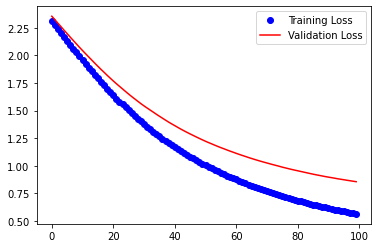

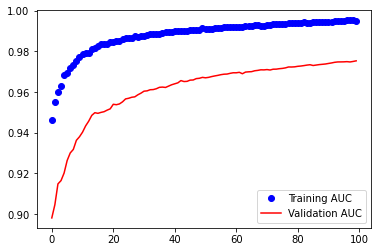

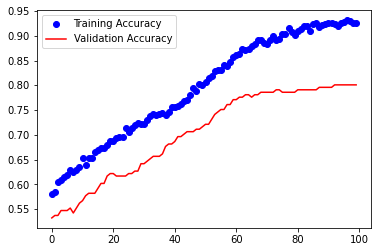

In [15]:
auc=history.history['auc']
val_auc=history.history['val_auc']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
______________________________________________________________________________________________

Block35_2_Branch_2_Conv2d_0c_3x (None, 17, 17, 32)   96          Block35_2_Branch_2_Conv2d_0c_3x3[
__________________________________________________________________________________________________
Block35_2_Branch_0_Conv2d_1x1_A (None, 17, 17, 32)   0           Block35_2_Branch_0_Conv2d_1x1_Bat
__________________________________________________________________________________________________
Block35_2_Branch_1_Conv2d_0b_3x (None, 17, 17, 32)   0           Block35_2_Branch_1_Conv2d_0b_3x3_
__________________________________________________________________________________________________
Block35_2_Branch_2_Conv2d_0c_3x (None, 17, 17, 32)   0           Block35_2_Branch_2_Conv2d_0c_3x3_
__________________________________________________________________________________________________
Block35_2_Concatenate (Concaten (None, 17, 17, 96)   0           Block35_2_Branch_0_Conv2d_1x1_Act
                                                                 Block35_2_Branch_1_Conv2d_0b_3x3_
          

Block17_6_Branch_1_Conv2d_0b_1x (None, 8, 8, 128)    0           Block17_6_Branch_1_Conv2d_0b_1x7_
__________________________________________________________________________________________________
Block17_6_Branch_0_Conv2d_1x1 ( (None, 8, 8, 128)    114688      Block17_5_Activation[0][0]       
__________________________________________________________________________________________________
Block17_6_Branch_1_Conv2d_0c_7x (None, 8, 8, 128)    114688      Block17_6_Branch_1_Conv2d_0b_1x7_
__________________________________________________________________________________________________
Block17_6_Branch_0_Conv2d_1x1_B (None, 8, 8, 128)    384         Block17_6_Branch_0_Conv2d_1x1[0][
__________________________________________________________________________________________________
Block17_6_Branch_1_Conv2d_0c_7x (None, 8, 8, 128)    384         Block17_6_Branch_1_Conv2d_0c_7x1[
__________________________________________________________________________________________________
Block17_6_

Block8_1_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    576         Block8_1_Branch_1_Conv2d_0b_1x3[0
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    0           Block8_1_Branch_1_Conv2d_0b_1x3_B
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1 (C (None, 3, 3, 192)    344064      Mixed_7a[0][0]                   
__________________________________________________________________________________________________
Block8_1_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    110592      Block8_1_Branch_1_Conv2d_0b_1x3_A
__________________________________________________________________________________________________
Block8_1_Branch_0_Conv2d_1x1_Ba (None, 3, 3, 192)    576         Block8_1_Branch_0_Conv2d_1x1[0][0
__________________________________________________________________________________________________
Block8_1_B

In [17]:
model2=Model(model.input,model.layers[-3].output)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

Block17_1_Conv2d_1x1 (Conv2D)   (None, 8, 8, 896)    230272      Block17_1_Concatenate[0][0]      
__________________________________________________________________________________________________
Block17_1_ScaleSum (Lambda)     (None, 8, 8, 896)    0           Mixed_6a[0][0]                   
                                                                 Block17_1_Conv2d_1x1[0][0]       
__________________________________________________________________________________________________
Block17_1_Activation (Activatio (None, 8, 8, 896)    0           Block17_1_ScaleSum[0][0]         
__________________________________________________________________________________________________
Block17_2_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    114688      Block17_1_Activation[0][0]       
__________________________________________________________________________________________________
Block17_2_Branch_1_Conv2d_0a_1x (None, 8, 8, 128)    384         Block17_2_Branch_1_Conv2d_0a_1x1[
__________

Mixed_7a_Branch_1_Conv2d_1a_3x3 (None, 3, 3, 256)    589824      Mixed_7a_Branch_1_Conv2d_0a_1x1_A
__________________________________________________________________________________________________
Mixed_7a_Branch_2_Conv2d_1a_3x3 (None, 3, 3, 256)    589824      Mixed_7a_Branch_2_Conv2d_0b_3x3_A
__________________________________________________________________________________________________
Mixed_7a_Branch_0_Conv2d_1a_3x3 (None, 3, 3, 384)    1152        Mixed_7a_Branch_0_Conv2d_1a_3x3[0
__________________________________________________________________________________________________
Mixed_7a_Branch_1_Conv2d_1a_3x3 (None, 3, 3, 256)    768         Mixed_7a_Branch_1_Conv2d_1a_3x3[0
__________________________________________________________________________________________________
Mixed_7a_Branch_2_Conv2d_1a_3x3 (None, 3, 3, 256)    768         Mixed_7a_Branch_2_Conv2d_1a_3x3[0
__________________________________________________________________________________________________
Mixed_7a_B

In [25]:
import cv2
import numpy as np

In [26]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [27]:
database = {}
database["Joelyne"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/DataCollection/Joelyne1/IMG_3752.jpg", model)
database["Diana"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Diana/IMG_1995.jpg",model)
database["David"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/David/IMG_1023.jpg", model)
database["Dorothy"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Dorothy/Dorothy1.jpg", model)
database["Gloria"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Gloria/Gloria1.jpg", model)
database["Denis"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Denis/Denis1.jpg", model)
database["Melissa"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Melissa/Melissa1.jpg", model)
database["Mel1"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Mel1/Mel1.jpg", model)
database["Maggie"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Mel2/Maggie1.jpg", model)
database["Geog"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Mel3/Geog1.jpg", model)
database["Ali"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Ali/Ali1.jpg", model)
database["Adonia"] = img_to_encoding("C:/Users/Diana/Desktop/Model Work/CroppedImages/ClusteredImages/Adonia/Adonia.jpg", model)

ValueError: in user code:

    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Diana\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 160, 160, 3), found shape=(1, 3, 286, 216)


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["name_of_the_output_node"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


'kerasFacenet.pb'

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: /tmp/saved-models/assets
x
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_1a_3x3/Conv2D
model_12/Conv2d_1a_3x3_BatchNorm/scale
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3
model_12/Conv2d_1a_3x3_Activation/Relu
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_2a_3x3/Conv2D
model_12/Conv2d_2a_3x3_BatchNorm/scale
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_2a_3x

'/tmp/saved-model/facenet-Original-LastLayer.pb'